# Data analytics coursework 

In [1]:
%load_ext autoreload
%autoreload 2

# Use HuggingFace's datasets library to access the financial_phrasebank dataset
from datasets import load_dataset
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from scipy.sparse import hstack
import nltk as nltk
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\adnan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\adnan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\adnan\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
train_files = [
    'data/FiQA_ABSA_task1/task1_headline_ABSA_train.json',
    'data/FiQA_ABSA_task1/task1_post_ABSA_train.json'
]

In [3]:
## Loading data from JSON
import json

def load_fiqa_sa_from_json(json_files):
    train_text = []
    train_labels = []

    for file in json_files:
        with open(file, 'r', encoding='UTF-8') as handle:
            dataf = json.load(handle)

        dataf_text = [dataf[k]["sentence"] for k in dataf.keys()]
        # print(len(dataf_text))
        train_text.extend(dataf_text)

        dataf_labels = [float(dataf[k]["info"][0]["sentiment_score"]) for k in dataf.keys()]
        # print(len(dataf_labels))
        train_labels.extend(dataf_labels)

    train_text = np.array(train_text)
    train_labels = np.array(train_labels)
    
    return train_text, train_labels


def threshold_scores(scores):
    """
    Convert sentiment scores to discrete labels.
    0 = negative.
    1 = neutral.
    2 = positive.
    """
    labels = []
    for score in scores:
        if score < -0.2:
            labels.append(0)
        elif score > 0.2:
            labels.append(2)
        else:
            labels.append(1)
            
    return np.array(labels)


all_text, all_labels = load_fiqa_sa_from_json(train_files)
    
print(f'Number of instances: {len(all_text)}')
print(f'Number of labels: {len(all_labels)}')

all_labels = threshold_scores(all_labels)
print(f'Number of negative labels: {np.sum(all_labels==0)}')
print(f'Number of neutral labels: {np.sum(all_labels==1)}')
print(f'Number of positive labels: {np.sum(all_labels==2)}')

Number of instances: 1111
Number of labels: 1111
Number of negative labels: 310
Number of neutral labels: 195
Number of positive labels: 606


In [4]:
from sklearn.model_selection import train_test_split

# Split test data from training data
train_documents, test_documents, train_labels, test_labels = train_test_split(
    all_text, 
    all_labels, 
    test_size=0.2, 
    stratify=all_labels  # make sure the same proportion of labels is in the test set and training set
)

# Split validation data from training data
train_documents, val_documents, train_labels, val_labels = train_test_split(
    train_documents, 
    train_labels, 
    test_size=0.2, 
    stratify=train_labels  # make sure the same proportion of labels is in the test set and training set
)

print(f'Number of training instances = {len(train_documents)}')
print(f'Number of validation instances = {len(val_documents)}')
print(f'Number of test instances = {len(test_documents)}')


Number of training instances = 710
Number of validation instances = 178
Number of test instances = 223


In [5]:
print(f'What does one instance look like from the training set? \n\n{train_documents[234]}')
print(f'...and here is its corresponding label \n\n{train_labels[234]}')

What does one instance look like from the training set? 

OCBC to Buy Barclay's Wealth Management Unit in Singapore, Hong Kong
...and here is its corresponding label 

2


# Preprocessing using Lemmatization

We create a lemmatizer token that reduces words to their root forms. This reduces the vocabulary size.


In [68]:
class LemmaTokenizer(object):
    
    def __init__(self):
        self.wnl = WordNetLemmatizer()
        
    def __call__(self, tweets):
        return [self.wnl.lemmatize(self.wnl.lemmatize(self.wnl.lemmatize(tok, pos='n'), pos='v'), pos='a') for tok in word_tokenize(tweets)]
    

# Using bi-grams + unigrams as feature

In [69]:
vectorizer = CountVectorizer(tokenizer=LemmaTokenizer(), ngram_range=(1,2))
vectorizer.fit(train_documents)
X_train = vectorizer.transform(train_documents)
X_val = vectorizer.transform(val_documents)
X_test_documents = vectorizer.transform(test_documents)
# Print out some of the features in the vocabulary:
print(list(vectorizer.vocabulary_)[:20])

C:\Users\adnan\anaconda3\envs\data_analytics\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['ocwen', 'reach', 'settlement', 'with', 'california', 'regulator', 'ocwen reach', 'reach settlement', 'settlement with', 'with california', 'california regulator', 'rt', '@', 'cash_cow', '$', 'tlt', 'still', 'ha', 'a', 'rise']


In [70]:
print(f'Vocabulary size: {len(vectorizer.vocabulary_)}')
vocabulary = vectorizer.vocabulary_

Vocabulary size: 10638


## Fitting to model

              precision    recall  f1-score   support

           0       0.75      0.54      0.63        50
           1       0.90      0.29      0.44        31
           2       0.69      0.94      0.79        97

    accuracy                           0.71       178
   macro avg       0.78      0.59      0.62       178
weighted avg       0.74      0.71      0.69       178



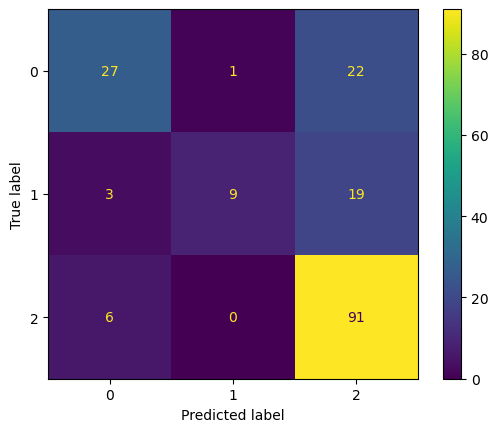

In [85]:
classifier = LogisticRegression()
classifier.fit(X_train, train_labels)
y_test_pred = classifier.predict(X_val)
cm = confusion_matrix(val_labels, y_test_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()
print(classification_report(val_labels, y_test_pred))

# Using POS-NEG lexicon features

In [72]:

analyser = SentimentIntensityAnalyzer()

In [73]:
vocabulary = vectorizer.vocabulary_

lex_pos_scores = np.zeros((1, len(vocabulary)))
lex_neg_scores = np.zeros((1, len(vocabulary)))

for i, term in enumerate(vocabulary):
    if term in analyser.lexicon and analyser.lexicon[term] > 0:
        lex_pos_scores[0, i] = 1
    elif term in analyser.lexicon and analyser.lexicon[term] < 0:
        lex_neg_scores[0, i] = 1

In [74]:
# This enables u to get the total positive and total negative counts for each set:
lex_pos_train = np.sum(X_train.multiply(lex_pos_scores), axis=1)
lex_pos_val = np.sum(X_val.multiply(lex_pos_scores), axis=1)
lex_pos_test = np.sum(X_test_documents.multiply(lex_pos_scores), axis=1)

lex_neg_train = np.sum(X_train.multiply(lex_neg_scores), axis=1)
lex_neg_val = np.sum(X_val.multiply(lex_neg_scores), axis=1)
lex_neg_test = np.sum(X_test_documents.multiply(lex_neg_scores), axis=1)

In [75]:
X_train = hstack((X_train, lex_pos_train, lex_neg_train))
X_val = hstack((X_val, lex_pos_val, lex_neg_val))
X_test_documents = hstack((X_test_documents, lex_pos_test, lex_neg_test))

## refitting model

              precision    recall  f1-score   support

           0       0.75      0.54      0.63        50
           1       0.90      0.29      0.44        31
           2       0.69      0.94      0.79        97

    accuracy                           0.71       178
   macro avg       0.78      0.59      0.62       178
weighted avg       0.74      0.71      0.69       178



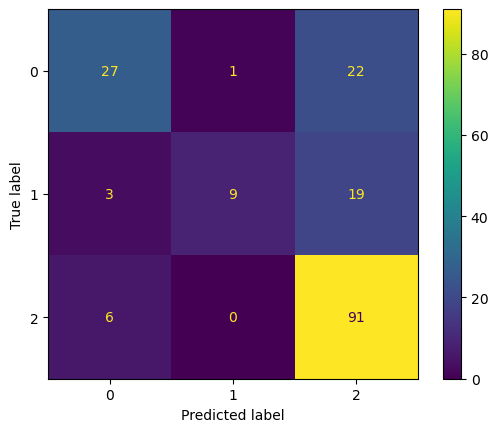

In [86]:

classifier = LogisticRegression()
classifier.fit(X_train, train_labels)
y_test_pred = classifier.predict(X_val)
# Checking performance
cm = confusion_matrix(val_labels, y_test_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()
print(classification_report(val_labels, y_test_pred))

In [77]:
# Key part is investigating the errors, so let's do that:
error_indexes = y_test_pred != val_labels  # compare predictions to gold labels

# get the text of tweets where the classifier made an error:
tweets_err = np.array(val_documents)[error_indexes]

# WRITE YOUR CODE HERE
pred_err = y_test_pred[error_indexes]
gold_err = np.array(val_labels)[error_indexes]

for i in range(10):  # just print the first ten
    print(f'Tweet: {tweets_err[i]}; true label = {gold_err[i]}, prediction = {pred_err[i]}.')

Tweet: CompaniesLSE adds ex-SEC head Schapiro to board; true label = 1, prediction = 2.
Tweet: $AMD big dumping... would not touch it for a while; true label = 0, prediction = 2.
Tweet: Looks like its booking a one way ticket to its 40 week MA near 50. Losing 10 week here $LULU http://chart.ly/7xb9h9b; true label = 1, prediction = 2.
Tweet: Sheryl Sandberg Sells 109,000 Shares of Facebook Inc $FB Stock https://t.co/3vXT7AMnpk via @RatingsNetwork; true label = 1, prediction = 2.
Tweet: $RIG whos ever pushing this is crazy, get ready for suspended dividend (turning into growth stock) blow out earnings, and major buyback, lol; true label = 1, prediction = 2.
Tweet: $SPY Tomorrow party time for the Bears!! $GOOG and $MSFT -5.5%; true label = 0, prediction = 2.
Tweet: $GPS Gap September Comparable Store Sales -4%; true label = 0, prediction = 2.
Tweet: Glencore fight back over debt fears lifts shares; true label = 2, prediction = 0.
Tweet: $ENDP being sued by FTC.....nobody will buy them wi

# Performance on test set

              precision    recall  f1-score   support

           0       0.68      0.55      0.61        62
           1       0.71      0.13      0.22        39
           2       0.69      0.94      0.80       122

    accuracy                           0.69       223
   macro avg       0.70      0.54      0.54       223
weighted avg       0.69      0.69      0.64       223



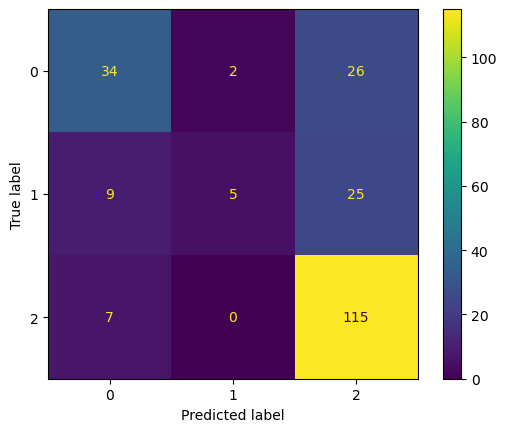

In [87]:
# Let's test the performance on the test set.
y_test_pred = classifier.predict(X_test_documents)
# Checking performance
cm = confusion_matrix(test_labels, y_test_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()
print(classification_report(test_labels, y_test_pred))

# HDP

In [6]:
from sklearn.model_selection import train_test_split

# Split test data from training data
train_documents, test_documents, train_labels, test_labels = train_test_split(
    all_text, 
    all_labels, 
    test_size=0.2, 
    stratify=all_labels  # make sure the same proportion of labels is in the test set and training set
)

# Split validation data from training data
train_documents, val_documents, train_labels, val_labels = train_test_split(
    train_documents, 
    train_labels, 
    test_size=0.2, 
    stratify=train_labels  # make sure the same proportion of labels is in the test set and training set
)

print(f'Number of training instances = {len(train_documents)}')
print(f'Number of validation instances = {len(val_documents)}')
print(f'Number of test instances = {len(test_documents)}')


Number of training instances = 710
Number of validation instances = 178
Number of test instances = 223


In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer 
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS # find stopwords
import numpy as np

np.random.seed(400)  # We fix the random seed to ensure we get consistent results when we repeat the lab.

# Tokenize and lemmatize
def preprocess(text):
    result=[]
    for token in simple_preprocess(text) :  # Tokenize, remove very short and very long words, convert to lower case, remove words containing non-letter characters
        if token not in STOPWORDS:
            result.append(WordNetLemmatizer().lemmatize(token, 'v'))
            
    return result

# Create a list of preprocessed documents
processed = []
for doc in train_documents:
    processed.append(preprocess(doc))

In [8]:
print(processed)

[['rsa', 'insurance', 'hire', 'towergate', 'egan', 'chief', 'financial', 'officer'], ['brewer', 'ab', 'inbev', 'seek', 'bln', 'tie', 'sabmiller'], ['rt', 'joemccann', 'correleation', 'dollar', 'index', 'spy', 'simply', 'amaze', 'dx', 'find', 'support', 'spy', 'retreat', 'like', 'clockwork'], ['fintech', 'provider', 'cafn', 'cachet', 'financial', 'solutions', 'surge', 'forward', 'today', 'post', 'earn', 'https', 'bj', 'csk', 'jkhy', 'fisv', 'momo'], ['technik', 'smaller', 'gild', 'pos', 'tender', 'cash', 'volatility', 'reluctant', 'big', 'position'], ['aapl', 'stock', 'climb', 'barron', 'see', 'upside', 'jim', 'cramer', 'https', 'lkld', 'mvkbq'], ['fti', 'breakout', 'today', 'report', 'earn', 'night'], ['tsla', 'february', 'low', 'amaze', 'rebound'], ['fb', 'small', 'long', 'call'], ['astrazeneca', 'profit', 'sales', 'stalwarts', 'fade'], ['mcd', 'look', 'set', 'fall', 'http', 'stks', 'fgj'], ['aapl', 'short', 'term', 'fund', 'redemption', 'liquidations', 'channel', 'clear', 'soon', 'so